In [4]:
#1 Read data source
import numpy as np
import pandas as pd
from geopy.geocoders import Bing
import matplotlib.pyplot as plt

# Read the Excel file into a DataFrame
raw_data = pd.read_csv('dataset_precios_combustibles.csv', sep=';', encoding = "ISO-8859-1",
                 lineterminator='\n', dtype={'Periodo': str})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585369 entries, 0 to 585368
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Periodo              585252 non-null  object 
 1   Mes                  585369 non-null  object 
 2   Codigo_departamento  585369 non-null  object 
 3   Departamento         585361 non-null  object 
 4   Codigo_municipio     585000 non-null  float64
 5   Municipio            585000 non-null  object 
 6   Nombre_comercial     584799 non-null  object 
 7   Bandera              584598 non-null  object 
 8   Direccion            584598 non-null  object 
 9   Producto             584229 non-null  object 
 10  Precio               580951 non-null  float64
 11  Estado               580952 non-null  object 
dtypes: float64(2), object(10)
memory usage: 53.6+ MB


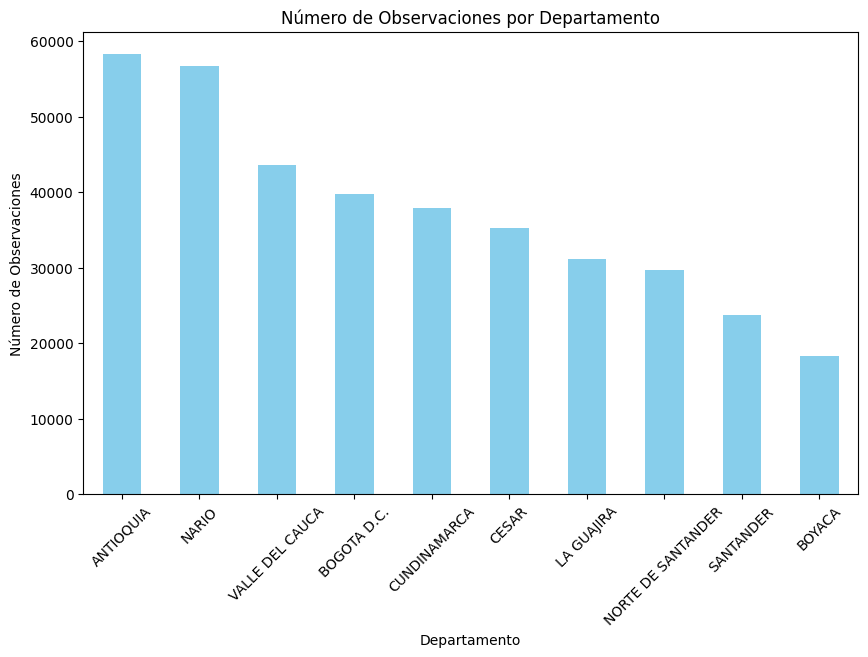

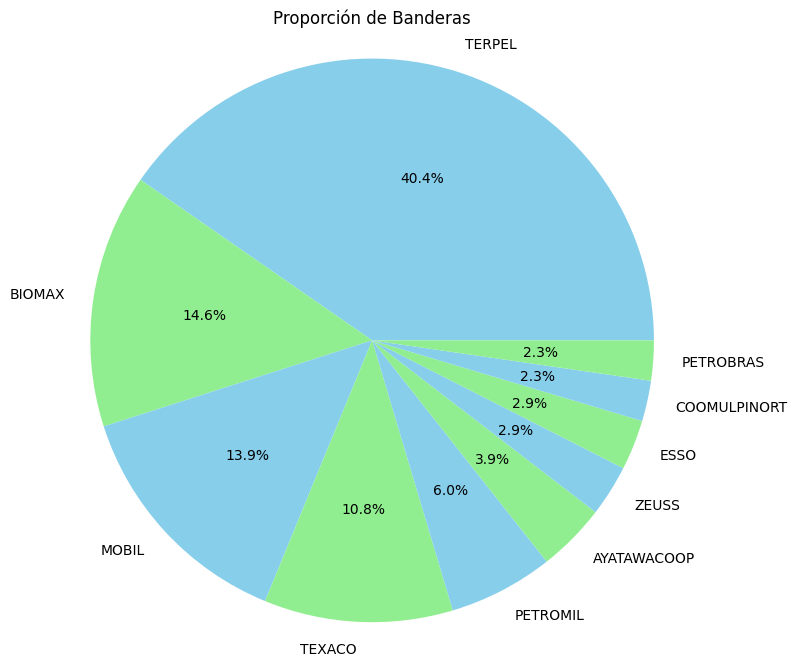

In [15]:
#2 Pre-analisys

raw_data.info()

# Conteo de observaciones por departamento
conteo_departamentos = raw_data['Departamento'].value_counts().nlargest(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_departamentos.plot(kind='bar', color='skyblue')
plt.xlabel('Departamento')
plt.ylabel('Número de Observaciones')
plt.title('Número de Observaciones por Departamento')
plt.xticks(rotation=45)
plt.show()

# -------------------------------------------------------------------------

conteo_banderas = raw_data['Bandera'].value_counts().nlargest(10)
plt.figure(figsize=(8, 8))
plt.pie(conteo_banderas, labels=conteo_banderas.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Proporción de Banderas')
plt.axis('equal')
plt.show()

In [13]:
# 3,1 Data transformation filtering
raw_data.columns = raw_data.columns.str.strip().str.replace('\r', '')
raw_data['Estado'] = raw_data['Estado'].str.replace('\r', '')

data_filtered_place = raw_data[(raw_data['Departamento'] == 'ANTIOQUIA') | (raw_data['Departamento'] == 'VALLE DEL CAUCA')]

df_2022 = data_filtered_place[(data_filtered_place['Periodo'] == '2022')]

df_gruped = df_2022.groupby(['Periodo', 'Codigo_departamento', 'Departamento', 'Codigo_municipio', 'Municipio', 'Nombre_comercial', 'Bandera', 'Direccion', 'Producto', 'Precio', 'Estado'])['Mes'].max()

# Nivelar el DataFrame agrupado
df_gruped = df_gruped.reset_index()

df_gruped.to_csv("resultado1.csv", encoding = "ISO-8859-1", sep=';');

# Convertir la Serie en un DataFrame
df = pd.DataFrame(df_gruped)

In [ ]:
# 3,2 Data transformation adding georeference

geolocator = Bing(api_key='Akuq0ICevbkx5zI1kZsgtZF6QujXu7SAsipkCiSSYsvrGE6vZKFGivkjkC9O5XN0')

# Función para obtener las coordenadas geográficas a partir de una dirección completa
def obtener_coordenadas(direccion_completa):
    try:

        location = geolocator.geocode(direccion_completa, timeout=10)  # Aumentamos el tiempo de espera a 10 segundos
        if location:
            print(location.latitude, location.longitude);
            return location.latitude, location.longitude
        else:
            print('none');
            return None, None
    except Exception as e:
        print(f"Error al obtener coordenadas para '{direccion_completa}': {e}")
        return None, None

# Combinar las columnas en una sola que contenga la dirección completa
df['direccion_completa'] = df['Direccion'] + ', '+ df['Municipio'] + ', ' + df['Departamento'] + ', ' + 'Colombia'

# Aplicar Geopy para obtener las coordenadas a partir de la dirección completa
df['lat'], df['long'] = zip(*df['direccion_completa'].apply(lambda x: obtener_coordenadas(x)))

df_gruped.to_csv("resultado_with_geo_final.csv", encoding = "ISO-8859-1", sep=';');